In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

## Clean, Convert, Impute

In [2]:
# Load data
data_file = 'coil+1999+competition+data/analysis.data'
col_names = ['season', 'river size', 'fluid velocity', 'cc_1', 'cc_2', 'cc_3', 'cc_4', 'cc_5', 'cc_6', 'cc_7', 'cc_8', 'ag_1', 'ag_2', 'ag_3', 'ag_4', 'ag_5', 'ag_6', 'ag_7']
df = pd.read_csv(data_file, names=col_names, header=None, na_values='XXXXXXX')
df_algae = df.copy()

# View missing data to decide how to handle
missing_values = df_algae.isnull().sum()
print("Missing values before imputation:\n", missing_values)

# Encode categorical variables
def encode_variables(dataframe):
    season_mapper = {'winter': 1, 'spring': 2, 'summer': 3, 'autumn': 4}
    dataframe['season'] = dataframe['season'].replace(season_mapper)

    river_size_mapper = {'small_': 1, 'medium': 2, 'large_': 3}
    dataframe['river size'] = dataframe['river size'].replace(river_size_mapper)

    fluid_velocity_mapper = {'low___': 1, 'medium': 2, 'high__': 3}
    dataframe['fluid velocity'] = dataframe['fluid velocity'].replace(fluid_velocity_mapper)

encode_variables(df_algae)

# Clean and convert 'cc_4' column
df_algae['cc_4'] = df_algae['cc_4'].str.replace('[^\d.]', '', regex=True)
df_algae['cc_4'] = pd.to_numeric(df_algae['cc_4'], errors='coerce')

# Convert remaining columns to numeric
numeric_columns = df_algae.select_dtypes(include=[np.number]).columns
df_algae[numeric_columns] = df_algae[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Impute missing values using KNN for numeric columns
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform')
df_algae[numeric_columns] = knn_imputer.fit_transform(df_algae[numeric_columns])



# Display the processed DataFrame
print(df_algae.head(5))


Missing values before imputation:
 season             0
river size         0
fluid velocity     0
cc_1               1
cc_2               2
cc_3              10
cc_4               2
cc_5               2
cc_6               2
cc_7               2
cc_8              12
ag_1               0
ag_2               0
ag_3               0
ag_4               0
ag_5               0
ag_6               0
ag_7              17
dtype: int64
   season  river size  fluid velocity  cc_1  cc_2    cc_3    cc_4       cc_5  \
0     1.0         1.0             2.0  8.00   9.8  60.800   6.238  578.00000   
1     2.0         1.0             2.0  8.35   8.0  57.750   1.288  370.00000   
2     4.0         1.0             2.0  8.10  11.4  40.020   5.330  346.66699   
3     2.0         1.0             2.0  8.07   4.8  77.364   2.302   98.18200   
4     4.0         1.0             2.0  8.06   9.0  55.350  10.416  233.70000   

      cc_6       cc_7  cc_8  ag_1  ag_2  ag_3  ag_4  ag_5  ag_6  ag_7  
0  105.000  170.00000

### Feature sets and feature correlation

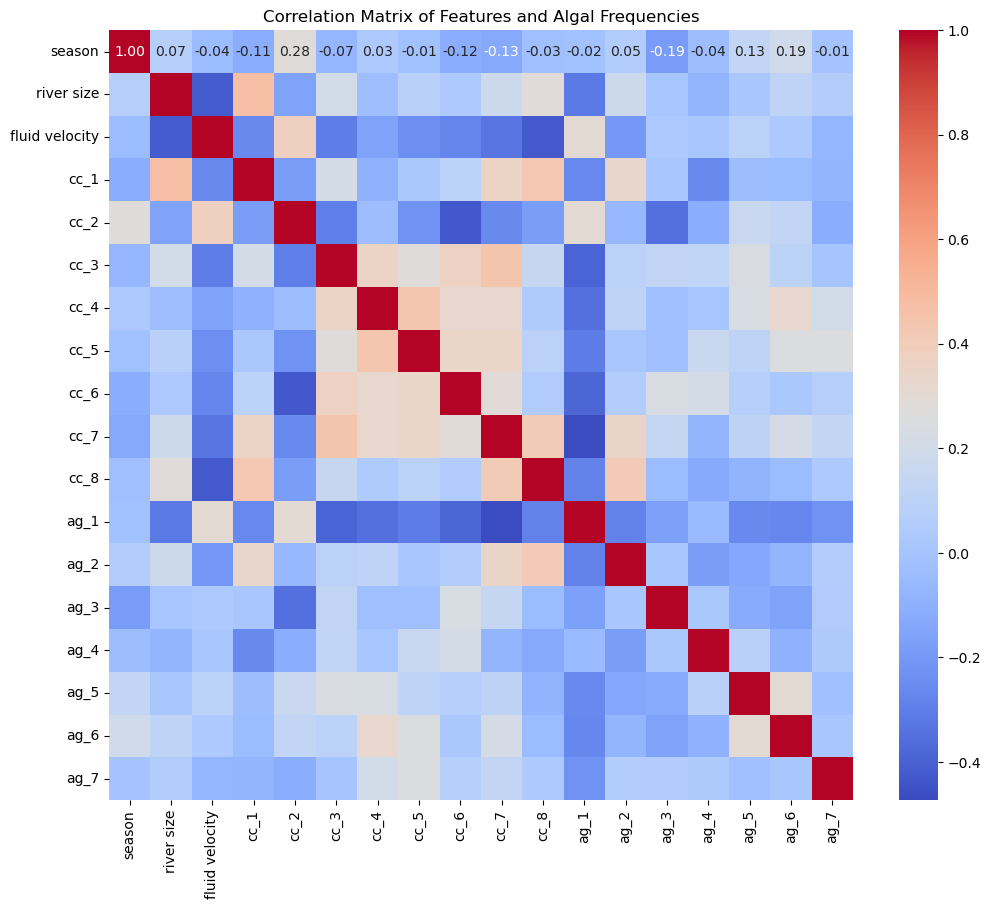

In [3]:
# Correlation matrix to determine strongest feature correlations
correlation_matrix = df_algae.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Features and Algal Frequencies')
plt.show()

# Define feature set (all features except target variables)
features = ['season', 'river size', 'fluid velocity', 'cc_1', 'cc_2', 'cc_3', 'cc_4', 'cc_5', 'cc_6', 'cc_7', 'cc_8']

# Define feature sets for each target
feature_sets = {
    'ag_1': features,
    'ag_2': features,
    'ag_3': features,
    'ag_4': features,
    'ag_5': features,
    'ag_6': features,
    'ag_7': features
}
# # Create and view heatmaps for each target
# for algae, feature_subset in feature_sets.items():
#     plt.figure(figsize=(10, 8))
#     correlation_matrix = df_algae[feature_subset + [algae]].corr()
#     sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
#     plt.title(f'Feature Correlation for {algae}')
#     plt.show()

### Training individual models

In [4]:
# Model training and hyperparameter tuning
results = []
trained_models = []

# Define the hyperparameter grid
param_grid = {
    'min_samples_leaf': [1, 2, 4, 6, 8, 10],
    'min_samples_split': [2, 5, 10, 15, 20],
    'n_estimators': [100],  # Fixing other parameters to isolate the effect
    'max_depth': [None]  # Use deep trees to focus on the leaf/split parameters
}

# Train models for each target
for algae, feature_subset in feature_sets.items():
    X = df_algae[feature_subset]
    y = df_algae[algae]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    grid_search = GridSearchCV(RandomForestRegressor(random_state=42, n_jobs=-1), param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    
    trained_models.append(best_model)
    
    results.append({
        'Algae': algae,
        'MSE': mse,
        'Best Parameters': grid_search.best_params_
    })
    
    print(f"Mean squared error for {algae}: {mse}")

    
print("Training Complete.")

Mean squared error for ag_1: 323.1391611480773
Mean squared error for ag_2: 59.06758831788168
Mean squared error for ag_3: 72.54690921026423
Mean squared error for ag_4: 9.87458642264981
Mean squared error for ag_5: 240.23723596771612
Mean squared error for ag_6: 37.327175644409266
Mean squared error for ag_7: 18.87237093150157
Training Complete.


#### Visualizing MSE and feature importance

Model Results:
  Algae         MSE                                    Best Parameters
0  ag_1  323.139161  {'max_depth': None, 'min_samples_leaf': 6, 'mi...
1  ag_2   59.067588  {'max_depth': None, 'min_samples_leaf': 4, 'mi...
2  ag_3   72.546909  {'max_depth': None, 'min_samples_leaf': 8, 'mi...
3  ag_4    9.874586  {'max_depth': None, 'min_samples_leaf': 10, 'm...
4  ag_5  240.237236  {'max_depth': None, 'min_samples_leaf': 4, 'mi...
5  ag_6   37.327176  {'max_depth': None, 'min_samples_leaf': 8, 'mi...
6  ag_7   18.872371  {'max_depth': None, 'min_samples_leaf': 6, 'mi...


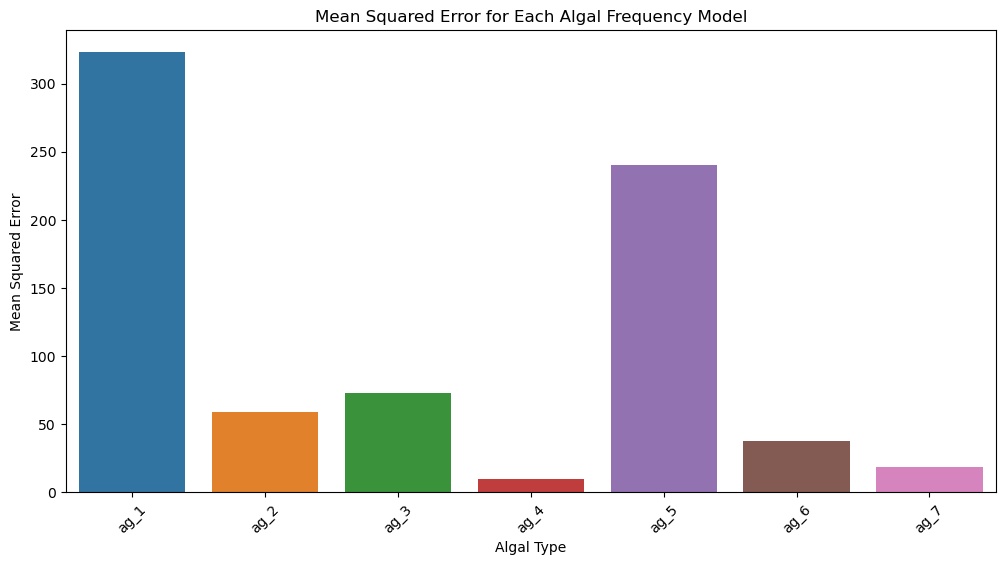

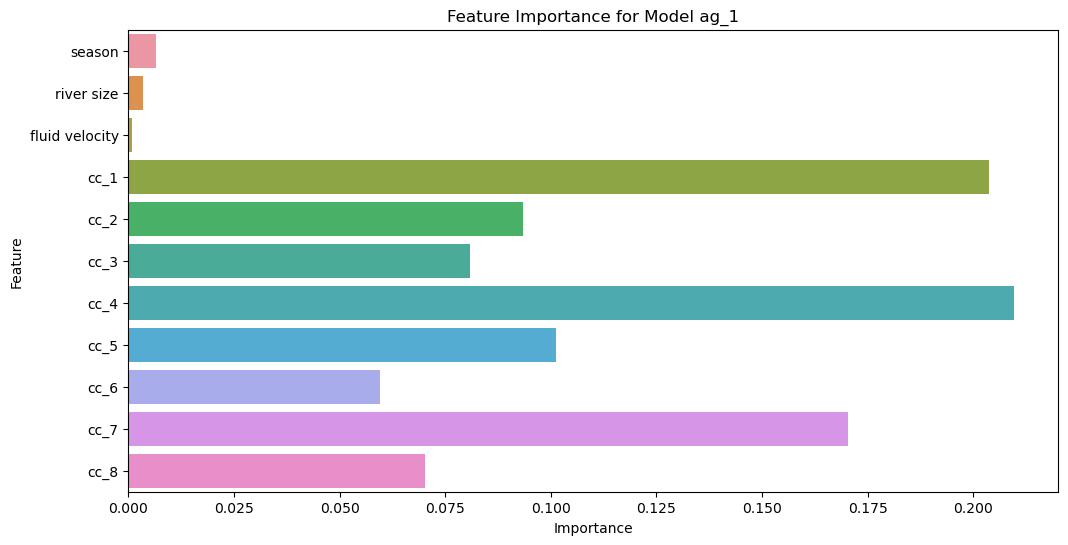

In [5]:
# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)
print("Model Results:")
print(results_df)

# Visualize MSE for each model
plt.figure(figsize=(12, 6))
sns.barplot(x='Algae', y='MSE', data=results_df)
plt.title('Mean Squared Error for Each Algal Frequency Model')
plt.ylabel('Mean Squared Error')
plt.xlabel('Algal Type')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.show()

# Feature importance visualization for one of the models (e.g., ag_1)
plt.figure(figsize=(12, 6))
sns.barplot(x=best_model.feature_importances_, y=pd.Series(features))  # Use the last best_model as example
plt.title('Feature Importance for Model ag_1')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

### Train a model using MultiOutputRegressor

In [6]:

targets = ['ag_1', 'ag_2', 'ag_3', 'ag_4', 'ag_5', 'ag_6', 'ag_7']

X = df_algae[features]
y = df_algae[targets]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(rf, param_grid=param_grid, cv=4, n_jobs=-1, verbose=1, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

print(f'Selected estimator {best_model}')
multi_target_rf = MultiOutputRegressor(best_model)
multi_target_rf.fit(X_train, y_train)

predictions = multi_target_rf.predict(X_test)

# test the performance of multi_target_rf on test data set
print(f'testing the performance of regressor {multi_target_rf} on test data . . .')
print('MSE error results for each target:\n')

for i, target in enumerate(targets):
    y_true = y_test[target]
    y_pred = predictions[:, i]
    mse = mean_squared_error(y_true, y_pred)
    print(f'mean squared error for {target}: {mse}')

Fitting 4 folds for each of 30 candidates, totalling 120 fits
Selected estimator RandomForestRegressor(min_samples_leaf=4, n_jobs=-1, random_state=42)
testing the performance of regressor MultiOutputRegressor(estimator=RandomForestRegressor(min_samples_leaf=4,
                                                     n_jobs=-1,
                                                     random_state=42)) on test data . . .
MSE error results for each target:

mean squared error for ag_1: 257.0009775116633
mean squared error for ag_2: 69.75375322494847
mean squared error for ag_3: 97.5290746324697
mean squared error for ag_4: 9.581920054715003
mean squared error for ag_5: 171.43731172852463
mean squared error for ag_6: 67.36696202311587
mean squared error for ag_7: 19.02142277933901


## Deploy Models on Evaluation Dataset

### Prepare evaluation and results data

In [7]:
# eval.data
eval_data = 'coil+1999+competition+data/eval.data'
# no targets included in evaluation dataset
eval_col_names = ['season', 'river size', 'fluid velocity', 'cc_1', 'cc_2', 'cc_3', 'cc_4', 'cc_5', 'cc_6', 'cc_7', 'cc_8']
df_eval = pd.read_csv(eval_data, names=eval_col_names, header=None, na_values='XXXXXXX')
encode_variables(df_eval)
# Clean and convert 'cc_4' column
df_eval['cc_4'] = df_eval['cc_4'].str.replace('[^\d.]', '', regex=True)
df_eval['cc_4'] = pd.to_numeric(df_algae['cc_4'], errors='coerce')

# Convert remaining columns to numeric
numeric_columns = df_eval.select_dtypes(include=[np.number]).columns
df_eval[numeric_columns] = df_eval[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Impute missing values using KNN for numeric columns
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform')
df_eval[numeric_columns] = knn_imputer.fit_transform(df_eval[numeric_columns])

# results.data
results_data = 'coil+1999+competition+data/results.data'
df_results = pd.read_csv(results_data, names=col_names, header=None, na_values='XXXXXXX')
encode_variables(df_results)
# Clean and convert 'cc_4' column
df_results['cc_4'] = df_results['cc_4'].str.replace('[^\d.]', '', regex=True)
df_results['cc_4'] = pd.to_numeric(df_results['cc_4'], errors='coerce')

# Convert remaining columns to numeric
numeric_columns = df_results.select_dtypes(include=[np.number]).columns
df_results[numeric_columns] = df_results[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Impute missing values using KNN for numeric columns
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform')
df_results[numeric_columns] = knn_imputer.fit_transform(df_results[numeric_columns])

# drop last eval row so eval and results are same size
df_eval = df_eval.iloc[:-1]

#### MSE performance for MultiOutputRegressor on eval.data

In [8]:
eval_data_predictions = multi_target_rf.predict(df_eval)
print('testing the performance of MultiOutputRegressor on Evaluation Dataset . . .')
# test the performance of multi_target_rf on eval data set
print(f'length of predictions: {len(eval_data_predictions)}')
for i, target in enumerate(targets):
    y_true = df_results[target]
    y_pred = eval_data_predictions[:, i]
    mse = mean_squared_error(y_true, y_pred)
    print(f'mean squared error for {target}: {mse}')

testing the performance of MultiOutputRegressor on Evaluation Dataset . . .
length of predictions: 140
mean squared error for ag_1: 220.21483415026964
mean squared error for ag_2: 102.69387485216329
mean squared error for ag_3: 28.628733466339867
mean squared error for ag_4: 5.890362572318947
mean squared error for ag_5: 79.05926381777236
mean squared error for ag_6: 181.97848782622262
mean squared error for ag_7: 21.558843464110698


#### MSE performance for Individually Trained Models on eval.data

In [9]:
def generate_predictions(eval_data, trained_models):
    predictions = {}
    for i, algae in enumerate(targets):
        X_eval = eval_data[features]
        predictions[algae] = trained_models[i].predict(X_eval)
    
    return predictions

predicted_distributions = generate_predictions(df_eval, trained_models)

# preparing to compare models performance predicting targets for evaluation data
Y_results = df_results[targets]

print('testing the performance of individually trained models on evaluation dataset')
for target in targets:
    y_true = Y_results[target]
    y_pred = predicted_distributions[target]
    mse = mean_squared_error(y_true, y_pred)
    print(f'Mean squared error for {target}: {mse}')

testing the performance of individually trained models on evaluation dataset
Mean squared error for ag_1: 226.1630877574509
Mean squared error for ag_2: 104.06273488699047
Mean squared error for ag_3: 29.485573042695243
Mean squared error for ag_4: 4.66066150935422
Mean squared error for ag_5: 76.68756106466812
Mean squared error for ag_6: 176.51664867574718
Mean squared error for ag_7: 22.014010964611817
